In [1]:
# @title Imports

import numpy as np

# Scikit-Learn for machine learning utilities
from sklearn.decomposition import PCA
from sklearn import manifold

# --- Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt

# --- Torch tools for the RNN
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# @title 3. RNN Model Definition {display-mode: "form"}
class MemoryRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=100, num_classes=10, rnn_type="RNN"):
        super().__init__()
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        else:
            self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x, return_seq=True):
        h_seq, _ = self.rnn(x)
        dropout = self.dropout(h_seq[:, -1])
        out = self.fc(dropout)
        if return_seq:
            return out, h_seq
        return out

In [4]:
class MemoryDataset(Dataset):
    def __init__(self, X, y, noise=None, noise_std=0.05):
        self.X = X
        self.y = y
        self.noise = noise
        self.noise_std = noise_std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.noise == "input":
            x = x + self.noise_std * torch.randn_like(x)

        return x, y

In [5]:
# @title Training Function (clean / input‑noise / weight‑noise) {display-mode: "form"}

def train_rnn(X, y, batch_size, variant, learning_rate, epochs=1000, noise_std=0.05):
    ds = MemoryDataset(X, y, noise="input" if variant=="input_noise" else None,
                       noise_std=noise_std)
    dl = DataLoader(ds, batch_size, shuffle=True, drop_last=False)
    print(len(dl))
    print(X.shape[1])

    model = MemoryRNN(X.shape[-1], rnn_type='GRU').to(device)
    opt   = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lossf = nn.CrossEntropyLoss()
    print(f" Training variant: {variant}")

    losses = [] # List to store loss at each epoch
    for ep in range(epochs):
        running = 0
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)

            # forward
            pred, _ = model(xb)
            #yb_class_idx = torch.argmax(yb, dim=0).to(torch.float32)
            loss = lossf(pred, yb)

            # weight noise variant
            if variant == "weight_noise":
                for p in model.parameters():
                    p.data += noise_std * torch.randn_like(p)

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            running += loss.item()
        epoch_loss = running / len(dl)
        losses.append(epoch_loss) # Store the loss
        print(f"  Epoch {ep+1}/{epochs} | loss={epoch_loss:.4f}")
    return model, losses # Return model and losses

In [6]:
# @title Model Evaluation

def evaluate_model(model, X_test, y_test, batch_size=128):
    model.eval() # Set model to evaluation mode
    test_ds = MemoryDataset(X_test, y_test)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    correct = 0
    total = 0
    hidden_states_list = []
    with torch.no_grad(): # Disable gradient calculations during evaluation
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            outputs, hidden_states = model(xb)
            _, predicted = torch.max(outputs.data, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()
            hidden_states_list.append(hidden_states)
    accuracy = 100 * correct / total
    print(f'\nAccuracy on test set: {accuracy:.2f}%')
    return accuracy, hidden_states_list

In [7]:
# @title MNIST Dataset preparation

import torchvision
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL Image to FloatTensor and scales to [0, 1]
    transforms.Normalize((0.1307,), (0.3081,)) # Standard normalization for MNIST
])

# Load MNIST training dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=mnist_transform,
    download=True
)

# Load MNIST test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=mnist_transform,
    download=True
)

# Prepare data for RNN: reshape images
# Each image (1, 28, 28) needs to become (28, 28) for the RNN,
# where 28 is sequence_length and 28 is input_dim.
# The DataLoader will add the batch dimension, making it (batch_size, 28, 28).

# Extract X and y from datasets and reshape
# X_train_mnist will be (num_samples, sequence_length, input_dim) -> (60000, 28, 28)
X_train_mnist = train_dataset.data.float().view(-1, 28, 28) # Reshape to (num_samples, 28, 28)
y_train_mnist = train_dataset.targets # Labels are already LongTensor (integers)

# X_test_mnist will be (num_samples, sequence_length, input_dim) -> (10000, 28, 28)
X_test_mnist = test_dataset.data.float().view(-1, 28, 28)
y_test_mnist = test_dataset.targets

100%|██████████| 9.91M/9.91M [00:00<00:00, 36.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.03MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.45MB/s]


In [8]:
#@title Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_clean, losses = train_rnn(X_train_mnist, y_train_mnist, batch_size=128, learning_rate=1e-3, epochs=20, variant="clean")

469
28
 Training variant: clean
  Epoch 1/20 | loss=0.9929
  Epoch 2/20 | loss=0.5509
  Epoch 3/20 | loss=0.4498
  Epoch 4/20 | loss=0.3816
  Epoch 5/20 | loss=0.3393
  Epoch 6/20 | loss=0.3156
  Epoch 7/20 | loss=0.2901
  Epoch 8/20 | loss=0.2752
  Epoch 9/20 | loss=0.2643
  Epoch 10/20 | loss=0.2576
  Epoch 11/20 | loss=0.2461
  Epoch 12/20 | loss=0.2343
  Epoch 13/20 | loss=0.2244
  Epoch 14/20 | loss=0.2192
  Epoch 15/20 | loss=0.2087
  Epoch 16/20 | loss=0.2100
  Epoch 17/20 | loss=0.2001
  Epoch 18/20 | loss=0.1997
  Epoch 19/20 | loss=0.1908
  Epoch 20/20 | loss=0.1900


In [11]:
def extract_hidden_states_and_labels(model, X_test, y_test, batch_size=128):
    model.eval()
    test_ds = MemoryDataset(X_test, y_test)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    hidden_mem_all = []
    labels_all = []

    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            outputs, h_seq = model(xb)  # h_seq shape: [batch, T, hidden_dim]
            h_seq_cpu = h_seq.cpu().numpy()  # shape: [B, T, D]
            hidden_mem_all.append(h_seq_cpu)
            labels_all.append(yb.cpu().numpy())

    # Combine batches into one array
    hidden_mem_all = np.concatenate(hidden_mem_all, axis=0)  # shape: [N, T, D]
    labels_all = np.concatenate(labels_all, axis=0)          # shape: [N]
    return hidden_mem_all, labels_all


In [12]:
hidden_mem_all, labels_all = extract_hidden_states_and_labels(model_clean, X_test_mnist, y_test_mnist)


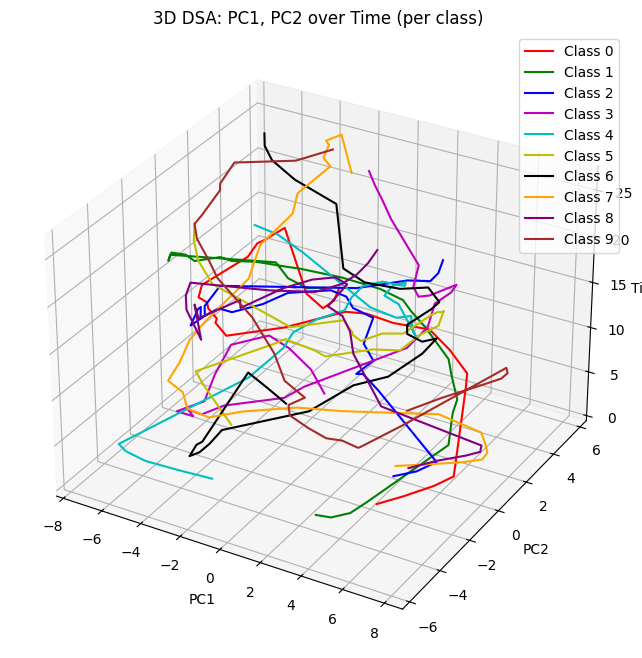

In [13]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k', 'orange', 'purple', 'brown']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for class_id in np.unique(labels_all):
    class_traj = hidden_mem_all[labels_all == class_id]
    if len(class_traj) == 0:
        continue
    sample_traj = class_traj[0]  # Take one sample per class
    pca = PCA(n_components=3)
    traj_3d = pca.fit_transform(sample_traj)  # shape: [T, 3]

    ax.plot(traj_3d[:, 0], traj_3d[:, 1], np.arange(traj_3d.shape[0]),
            label=f"Class {class_id}", color=colors[class_id % len(colors)])

ax.set_title("3D DSA: PC1, PC2 over Time (per class)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("Time")
ax.legend()
plt.show()


/tmp/ipython-input-16-3682447624.py:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



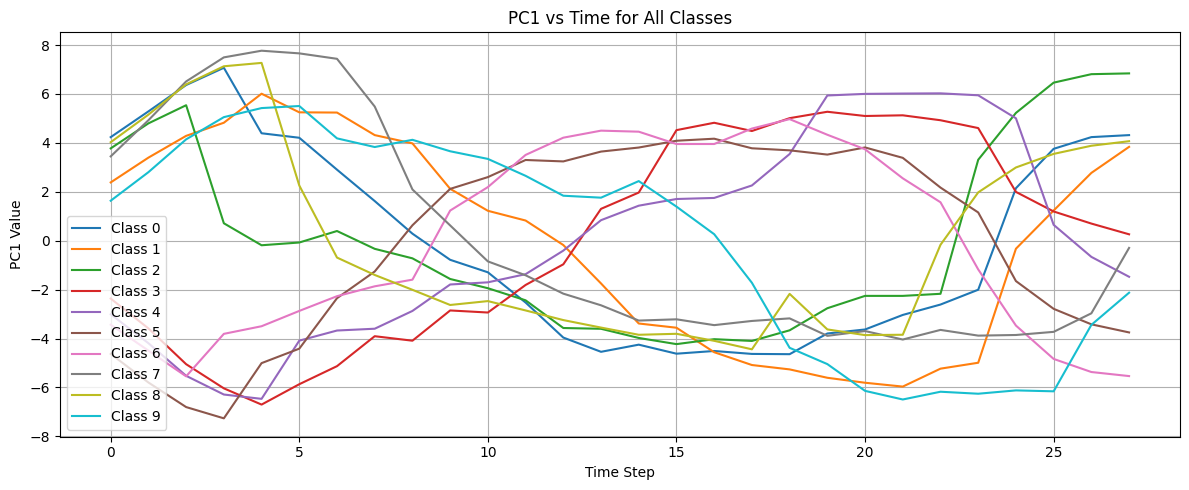

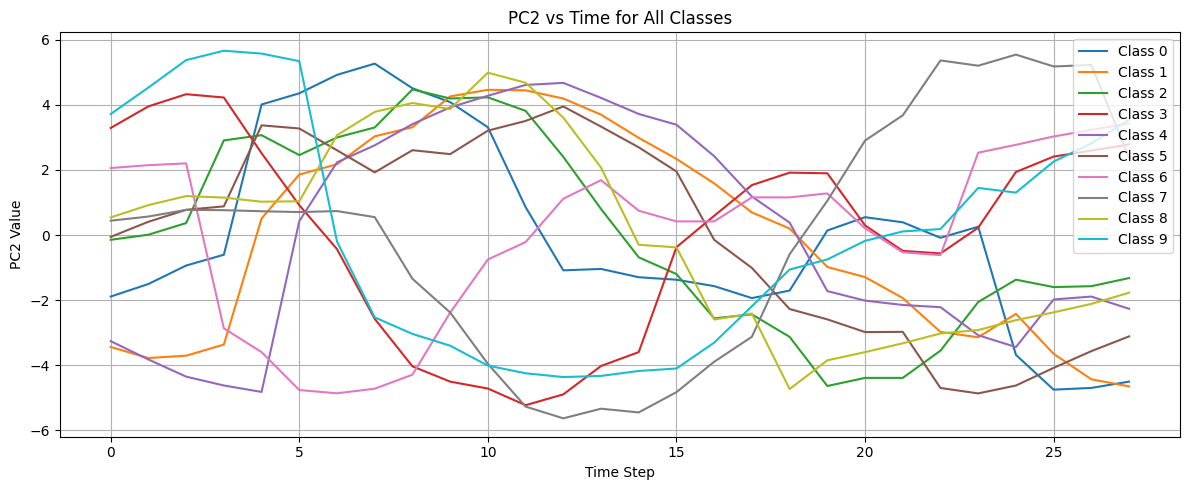

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Set up color map for different classes
colors = plt.cm.get_cmap('tab10', 10)  # 10 distinct colors for digits 0-9

# Initialize empty figures
plt.figure(figsize=(12, 5))
plt.title("PC1 vs Time for All Classes")
plt.xlabel("Time Step")
plt.ylabel("PC1 Value")

# PC1 vs Time
for class_id in np.unique(labels_all):
    class_traj = hidden_mem_all[labels_all == class_id]
    if len(class_traj) == 0:
        continue

    sample_traj = class_traj[0]  # shape: [T, H]
    pca = PCA(n_components=2)
    traj_2d = pca.fit_transform(sample_traj)

    time = np.arange(traj_2d.shape[0])
    plt.plot(time, traj_2d[:, 0], label=f'Class {class_id}', color=colors(class_id))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# PC2 vs Time
plt.figure(figsize=(12, 5))
plt.title("PC2 vs Time for All Classes")
plt.xlabel("Time Step")
plt.ylabel("PC2 Value")

for class_id in np.unique(labels_all):
    class_traj = hidden_mem_all[labels_all == class_id]
    if len(class_traj) == 0:
        continue

    sample_traj = class_traj[0]
    pca = PCA(n_components=2)
    traj_2d = pca.fit_transform(sample_traj)

    time = np.arange(traj_2d.shape[0])
    plt.plot(time, traj_2d[:, 1], label=f'Class {class_id}', color=colors(class_id))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
!pip install plotly

import plotly.graph_objs as go
from sklearn.decomposition import PCA
import numpy as np

def plot_dsa_plotly_all_classes(hidden_mem_all, labels_all):
    traces = []
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'olive']

    for class_id in np.unique(labels_all):
        class_traj = hidden_mem_all[labels_all == class_id]
        if len(class_traj) == 0:
            continue

        sample_traj = class_traj[0]
        pca = PCA(n_components=3)
        traj_3d = pca.fit_transform(sample_traj)

        trace = go.Scatter3d(
            x=traj_3d[:, 0],
            y=traj_3d[:, 1],
            z=np.arange(traj_3d.shape[0]),
            mode='lines',
            name=f"Class {class_id}",
            line=dict(color=colors[class_id % len(colors)])
        )
        traces.append(trace)

    fig = go.Figure(data=traces)
    fig.update_layout(title='DSA Trajectories for All Classes (Interactive)',
                      scene=dict(xaxis_title='PC1',
                                 yaxis_title='PC2',
                                 zaxis_title='Time'),
                      legend_title="Classes")
    fig.show()

plot_dsa_plotly_all_classes(hidden_mem_all, labels_all)



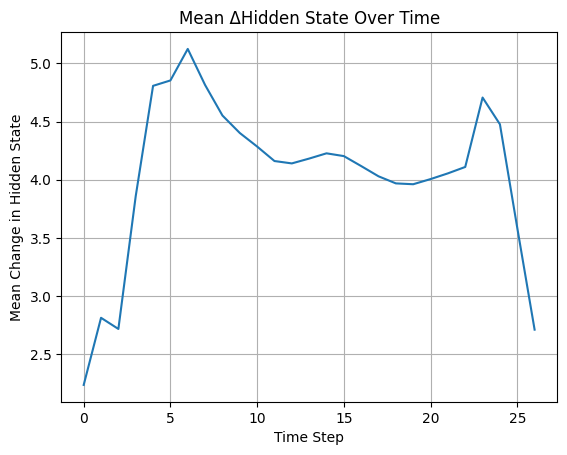

In [21]:
hidden_states = torch.tensor(hidden_mem_all)  # convert numpy to torch
delta = torch.norm(hidden_states[:, 1:, :] - hidden_states[:, :-1, :], dim=2)

mean_delta = delta.mean(dim=0).cpu().numpy()

import matplotlib.pyplot as plt
plt.plot(mean_delta)
plt.title("Mean ΔHidden State Over Time")
plt.xlabel("Time Step")
plt.ylabel("Mean Change in Hidden State")
plt.grid(True)
plt.show()
